# **FURTHER EXPERIMENTS**

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.express as px
import scipy.stats
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve, KFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, auc
from sklearn.pipeline import Pipeline
from scipy.stats import sem
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from collections import Counter
from sklearn.inspection import permutation_importance
import shap
import warnings
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, silhouette_score, calinski_harabasz_score
from itertools import combinations_with_replacement
from copy import deepcopy
from sklearn.neural_network import MLPClassifier, MLPRegressor
from kneed import KneeLocator
from sklearn.cluster import KMeans
from matplotlib.pyplot import figure
from kmodes.kmodes import KModes
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.encoder import cluster_encoder
from sklearn.metrics import pairwise_distances
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_selection import RFECV
from scipy.spatial.distance import cdist
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin
from math import sqrt
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import plotly.io as pio

warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [5]:
def log_likelihood(y_true, y_pred):
    """Calculate the log-likelihood loss between true labels and predicted labels.
    
    Args:
        y_true (numpy.ndarray): Array of true labels (0 or 1). Shape should be (n_samples,).
        y_pred (numpy.ndarray): Array of predicted probabilities for being label 1. Shape should be (n_samples,).
    
    Returns:
        float: Negative log-likelihood loss value.
    """

    # To prevent log(0)
    epsilon = 1e-7 
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    # Compute the log likelihood
    log_likelihood = y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)
    return -np.sum(log_likelihood)

In [6]:
def find_optimal_threshold(y_true, y_proba):
    """Find the optimal threshold for binary classification based on ROC curve.

    This function computes the Receiver Operating Characteristic (ROC) curve
    and then finds the threshold where the difference between True Positive Rate (TPR)
    and False Positive Rate (FPR) is maximized.

    Args:
        y_true (numpy.ndarray): Array of true labels (0 or 1). Shape should be (n_samples,).
        y_proba (numpy.ndarray): Array of predicted probabilities for being label 1. Shape should be (n_samples,).

    Returns:
        float: The optimal threshold for binary classification.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

In [7]:
def apply_smote(X_train, y_train):
    """Apply Synthetic Minority Over-sampling Technique (SMOTE) to training data.
    
    This function balances the class distribution in the training set by generating
    synthetic samples for the minority class using SMOTE.

    Args:
        X_train (numpy.ndarray or pandas.DataFrame): Training features. Shape should be (n_samples, n_features).
        y_train (numpy.ndarray or pandas.Series): Training labels. Shape should be (n_samples,).

    Returns:
        Tuple[numpy.ndarray, numpy.ndarray]: Resampled training features and labels.
        
        - X_train_res (numpy.ndarray): Resampled training features. Shape will be (n_resampled_samples, n_features).
        - y_train_res (numpy.ndarray): Resampled training labels. Shape will be (n_resampled_samples,).
    """
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

In [8]:
def create_poly_features(df, include_list=['PATIENT_AGE_AT_TREATMENT',
       'TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI'], degree=2):
    """
    Generates polynomial features with coherent names.

    Args:
        df (DataFrame): A pandas DataFrame containing the features.
        include_list (list): List of original features for which squared terms should be included.
        degree (int): The degree of the polynomial features. Default is 2.
    
    Returns:
        DataFrame: A new DataFrame with the polynomial features.
    """
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(df)

    # Generate coherent names
    poly_feature_names = []
    
    for d in range(1, degree+1):
        comb = combinations_with_replacement(df.columns, d)
        for i in list(comb):
            if len(set(i)) == 1:  # all elements in the combination are the same
                if d == 1: # no need to show power for d=1
                    poly_feature_names.append(i[0])
                else:
                    poly_feature_names.append(i[0] + "^" + str(d))
            else:
                poly_feature_names.append(" ".join(i))

    # Create a new DataFrame
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)

    if include_list is not None:
        # List of columns to drop
        drop_columns = [col for col in poly_df.columns if "^" in col and col.split("^")[0] not in include_list]
        poly_df.drop(columns=drop_columns, inplace=True)
    
    return poly_df

In [9]:
def model_pipeline(X_train, y_train, X_test, y_test, model, metrics_list, params={},
k=10, stratified=False, AIC=False, smote=False, SHAP=False,
optimal_threshold=True, importances=False):
    """Runs a machine learning model pipeline with various options.

    This function constructs a machine learning pipeline with optional techniques such as SMOTE
    and stratified k-fold cross-validation. It trains the model, evaluates it with specified metrics,
    and can optionally calculate AIC/BIC - to be used when dealing with parametric models, feature 
    importances, SHAP values, and optimal thresholds.

    Args:
        X_train (pandas.DataFrame): Training data.
        y_train (pandas.Series): Training labels.
        X_test (pandas.DataFrame): Test data.
        y_test (pandas.Series): Test labels.
        model (object): Uninitialized machine learning model.
        metrics_list (list of str): List of metrics to evaluate. Must be keys in the 'metrics' dictionary.
        params (dict, optional): Parameters to pass to the model. Default is an empty dictionary.
        k (int, optional): Number of folds in KFold cross-validation. Default is 10.
        stratified (bool, optional): Whether to use StratifiedKFold. Default is True.
        AIC (bool, optional): Whether to compute Akaike Information Criterion. Default is False.
        smote (bool, optional): Whether to use SMOTE for oversampling. Default is False.
        SHAP (bool, optional): Whether to compute SHAP values. Default is False.
        optimal_threshold (bool, optional): Whether to find optimal threshold for classification. Default is True.
        importances (bool, optional): Whether to compute feature importances. Default is False.

    Returns:
        dict: Dictionary containing various evaluation results such as cross-validation scores,
            test scores, feature importances, and more. The specific keys depend on the input arguments.
    """
    
    # Map metric names to functions
    metrics = {
        'accuracy': balanced_accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'f1_score': f1_score,
        'auc': roc_auc_score,
        }

    # Create a pipeline with the specified model and parameters
    steps = []
    # Check if polynomial features are requested and add to the pipeline if necessary

    if smote:
        steps.append(('smote', SMOTE()))
        
    steps.append(('model', model(**params)))
    #pipeline = Pipeline(steps)
    pipeline = ImbPipeline(steps)

    # Initialize KFold cross-validation or Stratified KFold if stratified=True
    if stratified:
        cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
    else:
        cv = KFold(n_splits=k, shuffle=True, random_state=1)

    # Compute the specified metrics using cross-validation
    cv_results = {}
    thresholds = []
    for metric in metrics_list:
        scorer = make_scorer(metrics[metric])
        cv_scores = []
        for train_index, test_index in cv.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

            pipeline.fit(X_train_fold, y_train_fold)

            if optimal_threshold and metric != 'auc':
                y_train_proba_fold = pipeline.predict_proba(X_train_fold)[:, 1]
                threshold = find_optimal_threshold(y_train_fold, y_train_proba_fold)
                thresholds.append(threshold)
            else:
                threshold = 0.5
                
            y_val_pred_proba = pipeline.predict_proba(X_val_fold)[:, 1]

            if metric == 'auc':
                cv_scores.append(scorer._score_func(y_val_fold, y_val_pred_proba))
            else:
                y_val_pred = (y_val_pred_proba >= threshold).astype(int)
                cv_scores.append(scorer._score_func(y_val_fold, y_val_pred))

        # Calculate confidence intervals
        cv_results[metric] = (np.mean(cv_scores), np.std(cv_scores))

    cv_results = pd.DataFrame(cv_results, columns=metrics_list).T
    cv_results.columns = ['Mean', 'Standard Deviation',]
    cv_results = cv_results.T

    # Compute the average optimal threshold from cross-validation
    avg_threshold = np.mean(thresholds) if thresholds else 0.5
    print('Average optimal threshold = ' + str(round(avg_threshold, 3)))

    # Fit the model on the full training set
    pipeline.fit(X_train, y_train)

    # Feature importances
    if importances:
        feature_importances = []
        for train_index, test_index in cv.split(X_train, y_train):
            X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

            pipeline.fit(X_train_fold, y_train_fold)
            fitted_model = pipeline.named_steps['model']

            if hasattr(fitted_model, 'feature_importances_'):
                fold_importance = fitted_model.feature_importances_
            elif hasattr(fitted_model, 'coef_'):
                fold_importance = np.abs(fitted_model.coef_[0])
            else:
                perm_importance = permutation_importance(fitted_model, X_test_fold, y_test_fold)
                fold_importance = perm_importance.importances_mean

            feature_importances.append(fold_importance)

        # Compute mean and standard deviation of feature importances
        feature_importances_mean = np.mean(feature_importances, axis=0)
        feature_importances_std = np.std(feature_importances, axis=0)
        
        importances_df = pd.DataFrame({
            'feature': X_train.columns,
            'importance_mean': feature_importances_mean,
            'importance_std': feature_importances_std
            })
        
        # Sort by importance_mean in descending order
        importances_df = importances_df.sort_values(by='importance_mean', ascending=False)
    
    else:
        importances_df = pd.DataFrame()

    # Compute the specified metrics on the test set
    test_results = {}
    for metric in metrics_list:
        scorer = metrics[metric]
        y_test_proba = pipeline.predict_proba(X_test)[:, 1]
        if metric == 'auc':
            test_score = scorer(y_test, y_test_proba)
        else:
            y_test_pred = (y_test_proba >= avg_threshold).astype(int)
            test_score = scorer(y_test, y_test_pred)
        test_results[metric] = test_score

    test_results = pd.DataFrame(test_results, index=['Value'], columns=metrics_list).T
    test_results = test_results.T

    # Compute the confusion matrix on the test set
    conf_matrix = confusion_matrix(y_test, y_test_pred) 

    # Output mean and std of cross-validation scores and test set scores
    output = {
        'cv_results': cv_results,
        'test_results': test_results,
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba, 
    }

    if AIC:
        y_pred_train_prob = pipeline.predict_proba(X_train)[:, 1] # Get predicted probabilities for the positive class
        n = X_train.shape[0] # Number of observations
        k = len(pipeline.named_steps['model'].coef_[0]) + 1 # Number of parameters in the model, adding 1 for intercept
        logL = log_likelihood(y_train, y_pred_train_prob)
        aic = 2 * k - 2 * logL
        bic = np.log(n) * k - 2 * logL
        output['aic'] = aic
        print('AIC: '+str(round(aic, 3)))
        output['bic'] = bic
        print('BIC: '+str(round(bic, 3)))

    output['feature_importances'] = importances_df

    # Print CV results
    print('')
    print('CV RESULTS')
    display(cv_results)
    print('')

    #Print Test results
    print('TEST RESULTS')
    display(test_results)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Live Birth', 'Live Birth'])
    disp.plot(cmap="Greens",  colorbar=False)
    plt.title('Test Set Confusion Matrix')
    plt.grid(False)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=600)
    plt.show()
    print('')

    #Print Features analysis
    if importances:
        print('FEATURES ANALYSIS')
        display(importances_df.head(20))

    if SHAP:
        # Compute SHAP values
        if hasattr(pipeline.named_steps['model'], 'feature_importances_'):
            explainer = shap.TreeExplainer(pipeline.named_steps['model'])
            shap_values = explainer.shap_values(X_train)

            # Create a SHAP summary plot
            shap.summary_plot(shap_values, X_train, plot_size=[20,10], max_display=20)

        elif hasattr(pipeline.named_steps['model'], 'coef_'):
            explainer = shap.LinearExplainer(pipeline.named_steps['model'], X_train)
            shap_values = explainer.shap_values(X_train)

            # Create a SHAP summary plot
            shap.summary_plot(shap_values, X_train, plot_size=[20,10], max_display=20)

    return output

In [10]:
def compute_grid_search(model, param_grid, X_train, y_train):
    """
    Perform a grid search on a model using Stratified K-Fold cross-validation.
    
    Parameters:
    - model: Estimator or model to be used.
    - param_grid: Dictionary of parameters for grid search.
    - X_train: Training data features.
    - y_train: Training data labels.
    
    Returns:
    - grid_search: Fitted GridSearchCV object.
    """

    # Create StratifiedKFold instance
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    # Set up the grid search with 'balanced_accuracy' as the scoring metric
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid, 
        cv=skf, 
        scoring='balanced_accuracy',  # Using balanced accuracy directly as the scoring metric
        verbose=1,  
        n_jobs=-1   
    )
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    print(grid_search.best_params_)
    
    return grid_search


## Sensitivity to SPECIFIC_TREATMENT_TYPE

In [102]:
TRAIN = pd.read_parquet('TRAIN_2016.parquet')
TEST = pd.read_parquet('TEST_2016.parquet')

In [107]:
# Separate the targets from the data
y_train_live_birth = TRAIN['LIVE_BIRTH_OCCURRENCE']
y_test_live_birth = TEST['LIVE_BIRTH_OCCURRENCE']

# Remove SPECIFIC_TREATMENT_TYPE_IVF variable
X_train = TRAIN.drop(['FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'LIVE_BIRTH_OCCURRENCE', 'SPECIFIC_TREATMENT_TYPE_IVF'], axis=1)
X_test = TEST.drop(['FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'LIVE_BIRTH_OCCURRENCE', 'SPECIFIC_TREATMENT_TYPE_IVF'], axis=1)

In [108]:
X_train_poly = create_poly_features(X_train)
X_test_poly = create_poly_features(X_test)

Average optimal threshold = 0.515
AIC: -43988.081
BIC: -43406.954

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.606044,0.341246,0.738657,0.466782,0.640050
Standard Deviation,0.008690,0.006943,0.010587,0.007421,0.009671



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.602908,0.339786,0.728477,0.463418,0.633088


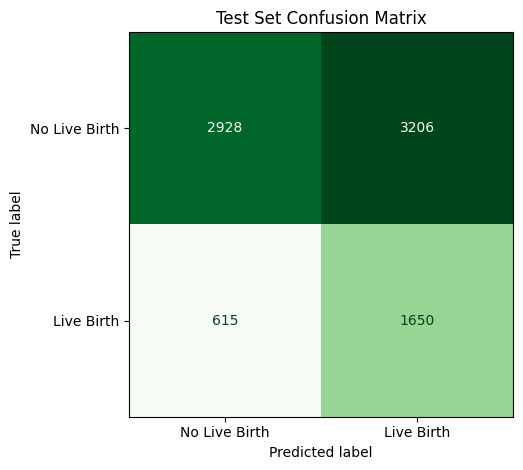


FEATURES ANALYSIS


,feature,importance_mean,importance_std
7,STIMULATION_USED,0.538500,0.100213
62,STIMULATION_USED SPERM_FROM,0.392601,0.032934
54,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED STIM...,0.257726,0.013367
47,CAUSE_OF_INFERTILITY__MALE_FACTOR CAUSE_OF_INF...,0.206840,0.027098
6,CAUSE_OF_INFERTILITY__ENDOMETRIOSIS,0.166470,0.039916
43,CAUSE_OF_INFERTILITY__OVULATORY_DISORDER STIMU...,0.157786,0.020647
36,CAUSE__OF_INFERTILITY__TUBAL_DISEASE STIMULATI...,0.122620,0.024425
64,STIMULATION_USED PREVIOUS_LIVE_BIRTH_IVF_OR_DI,0.118290,0.093535
1,TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI,0.114841,0.027105
57,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED PREV...,0.101432,0.039095


In [110]:
# Optimal Squared Logistic Regression
X_train_poly = create_poly_features(X_train)
X_test_poly = create_poly_features(X_test)
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':4000, 'random_state': 42, 'class_weight': 'balanced', 'penalty':'l1', 'solver':'saga', 'C':0.1}
results_C_01 = model_pipeline(X_train_poly, y_train_live_birth, X_test_poly, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True, importances=True)

## ADDING FROZEN CYCLES

In [108]:
FRESH_FROZEN_2016 = pd.read_parquet('FRESH_FROZEN_2016.parquet')
y = FRESH_FROZEN_2016['LIVE_BIRTH_OCCURRENCE']
FRESH_FROZEN_2016 = FRESH_FROZEN_2016.drop(['FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'LIVE_BIRTH_OCCURRENCE'], axis=1)
X_train_frozen, X_test_frozen, y_train_frozen, y_test_frozen = train_test_split(FRESH_FROZEN_2016, y, test_size=0.2, random_state=42, stratify=y)

In [109]:
X_train_frozen['FRESH_CYCLE'].value_counts()

1    33497
0     3989
Name: FRESH_CYCLE, dtype: int64

In [110]:
X_test_frozen['FRESH_CYCLE'].value_counts()

1    8378
0     994
Name: FRESH_CYCLE, dtype: int64

Average optimal threshold = 0.494
AIC: -49045.477
BIC: -48149.646

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.604524,0.339167,0.752246,0.467511,0.635746
Standard Deviation,0.009856,0.006727,0.015621,0.008792,0.008101



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.603277,0.337555,0.757301,0.466967,0.639834


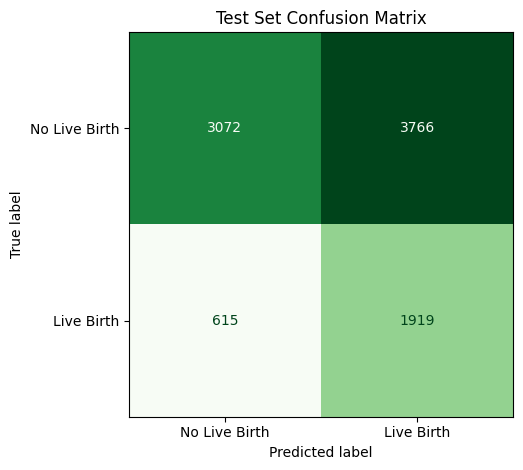

In [103]:
# Squared Logistic Regression
X_train_frozen_poly = create_poly_features(X_train_frozen)
X_test_frozen_poly = create_poly_features(X_test_frozen)
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':4000, 'random_state': 42, 'class_weight': 'balanced'}
results_LR2 = model_pipeline(X_train_frozen_poly, y_train_frozen, X_test_frozen_poly, y_test_frozen, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True)

In [104]:
# Further investigation

# Add model predictions and ground truths back to dataframe
X_test_frozen_investigation = X_test_frozen.copy()
X_test_frozen_investigation['GT'] = y_test_frozen
X_test_frozen_investigation['PREDS'] = results_LR2['y_test_pred']

# Filter to only keep frozen cycles
X_test_frozen_investigation = X_test_frozen_investigation[X_test_frozen_investigation['FRESH_CYCLE']==0]

# Extract predictions and ground truths
frozen_preds = X_test_frozen_investigation['PREDS']
frozen_gt = X_test_frozen_investigation['GT']

# Compute metrics for the sub-population
balanced_acc = balanced_accuracy_score(frozen_gt, frozen_preds)
roc_auc = roc_auc_score(frozen_gt, frozen_preds)
f1 = f1_score(frozen_gt, frozen_preds)
conf_matrix = confusion_matrix(frozen_gt, frozen_preds)

# Print metrics and confusion matrix
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Balanced Accuracy: 0.5352
ROC AUC: 0.5352
F1 Score: 0.3986

Confusion Matrix:
[[303 429]
 [ 90 172]]


In [117]:
y_train_live_birth.value_counts()[1]/(y_train_live_birth.value_counts()[0]+y_train_live_birth.value_counts()[1])

0.26959368953713353

## COMPARING PERFORMANCE OVER THE YEARS

In [10]:
def year_iterator(data_list, X_test, y_test):
    """
    Iterates over a list of datasets and trains squared logistic regression models for them.
    These models are all evalauted on the same test set. The function prints various metrics 
    and results for each dataset.

    Args:
        data_list (list of str): A list of paths to dataset files in parquet format.
        X_test (pandas.DataFrame): Features for the test set.
        y_test (pandas.Series): Target variable for the test set.

    Returns:
        None: This function only prints results and does not return a value.
    """

    for dataset in data_list:

        print('COMPUTING FOR '+str(dataset))

        DATA = pd.read_parquet(dataset)
        y_train = DATA['LIVE_BIRTH_OCCURRENCE']
        X_train = DATA.drop(['FRESH_CYCLE', 'FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'LIVE_BIRTH_OCCURRENCE'], axis=1)

        # Squared Logistic Regression
        X_train_poly = create_poly_features(X_train)
        X_test_poly = create_poly_features(X_test)
        model = LogisticRegression
        metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
        params = {'max_iter':4000, 'random_state': 42, 'class_weight': 'balanced'}
        results_LR2 = model_pipeline(X_train_poly, y_train, X_test_poly, y_test, model, metrics_list, params, 
        k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True)
        print('')
        print('')

    return None


COMPUTING FOR HFEA_2006.parquet
Average optimal threshold = 0.518
AIC: -42301.177
BIC: -41538.123

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.604093,0.324316,0.661580,0.435126,0.641805
Standard Deviation,0.009663,0.006662,0.028467,0.010418,0.010745



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.598253,0.342607,0.674172,0.454329,0.635336


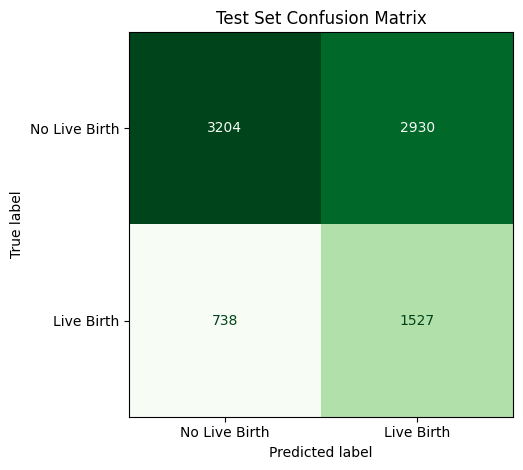




COMPUTING FOR HFEA_2007.parquet
Average optimal threshold = 0.496
AIC: -43736.5
BIC: -42970.192

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.604919,0.324317,0.720719,0.447075,0.645349
Standard Deviation,0.005430,0.006050,0.027047,0.004591,0.006767



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.609357,0.343859,0.740397,0.469616,0.640537


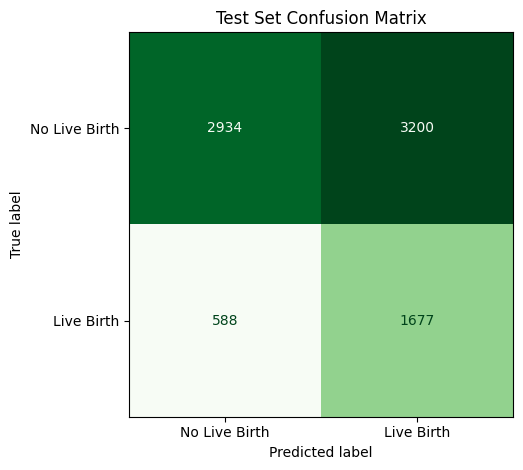




COMPUTING FOR HFEA_2008.parquet
Average optimal threshold = 0.501
AIC: -48088.578
BIC: -47313.734

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.609439,0.333536,0.712028,0.454221,0.645963
Standard Deviation,0.006934,0.004249,0.019973,0.007019,0.004922



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.610652,0.346566,0.728477,0.469684,0.640305


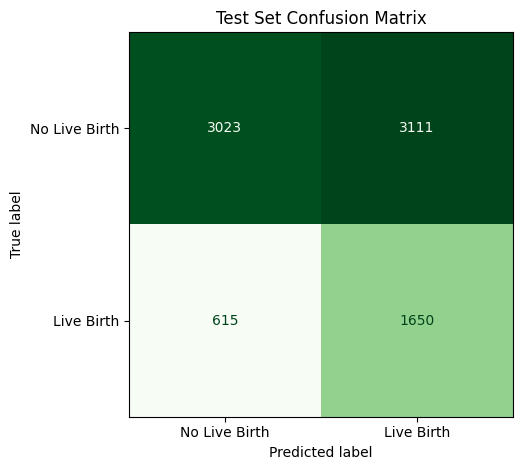




COMPUTING FOR HFEA_2009.parquet
Average optimal threshold = 0.505
AIC: -52030.967
BIC: -51249.533

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.602642,0.320858,0.723472,0.444523,0.635617
Standard Deviation,0.009632,0.006609,0.016991,0.008744,0.010386



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.613457,0.346091,0.750552,0.473736,0.639761


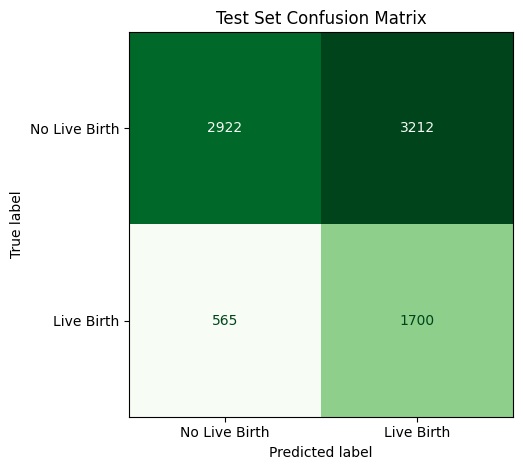




COMPUTING FOR HFEA_2010.parquet
Average optimal threshold = 0.517
AIC: -54392.922
BIC: -53607.629

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.598914,0.327543,0.680171,0.442019,0.632578
Standard Deviation,0.007060,0.003360,0.029602,0.008127,0.010703



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.612863,0.351434,0.708609,0.469848,0.639109


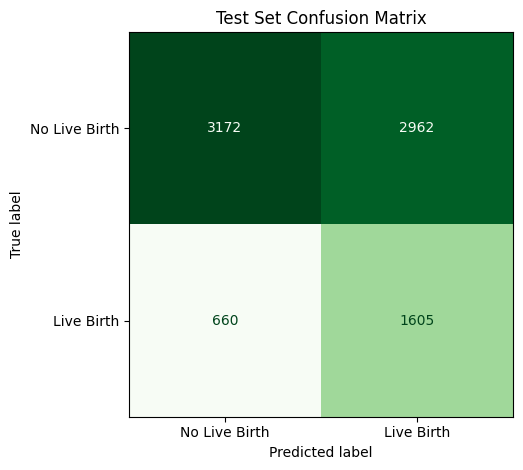




COMPUTING FOR HFEA_2011.parquet
Average optimal threshold = 0.511
AIC: -56385.669
BIC: -55597.1

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.599782,0.323143,0.713518,0.444728,0.632706
Standard Deviation,0.006073,0.004618,0.020746,0.005906,0.007281



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.610224,0.345127,0.736424,0.469992,0.637772


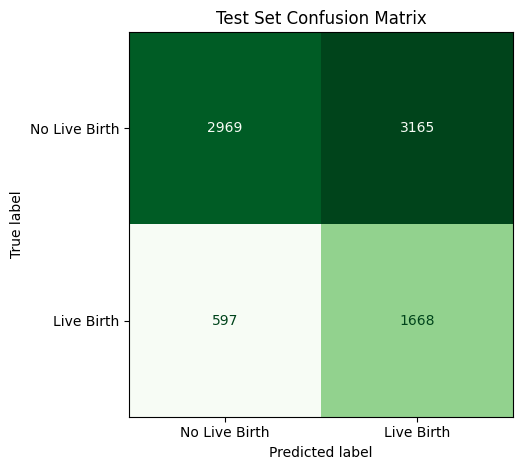




COMPUTING FOR HFEA_2012.parquet
Average optimal threshold = 0.501
AIC: -57793.38
BIC: -57002.484

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.600299,0.330588,0.728312,0.454599,0.633754
Standard Deviation,0.005365,0.004197,0.025135,0.005630,0.005480



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.613912,0.346601,0.749669,0.474037,0.640523


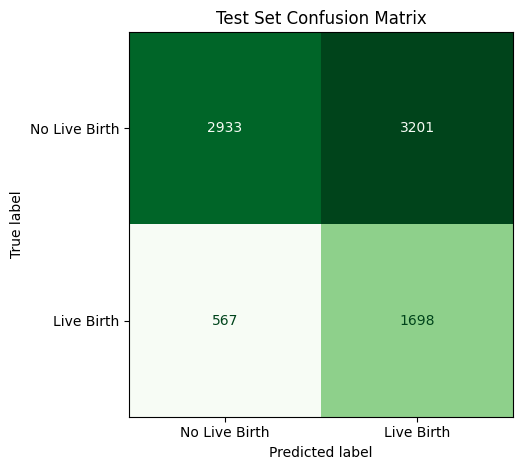




COMPUTING FOR HFEA_2013.parquet
Average optimal threshold = 0.52
AIC: -57499.275
BIC: -56708.727

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.602258,0.343087,0.718472,0.464345,0.630567
Standard Deviation,0.007553,0.005896,0.016513,0.007078,0.008290



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.612696,0.34779,0.732892,0.471725,0.636992


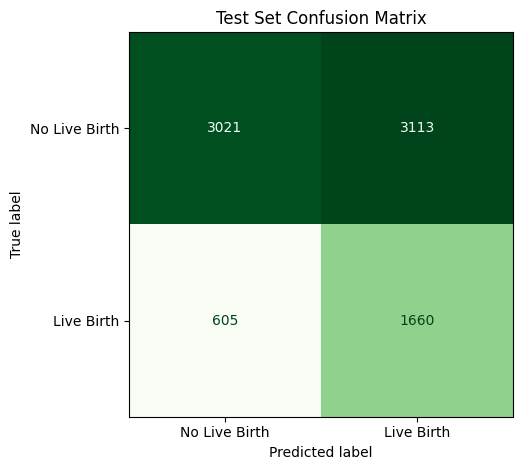




COMPUTING FOR HFEA_2014.parquet
Average optimal threshold = 0.511
AIC: -57036.232
BIC: -56245.681

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.608808,0.354250,0.72572,0.475939,0.643627
Standard Deviation,0.011687,0.008998,0.02553,0.010870,0.011012



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.613963,0.348618,0.735099,0.472944,0.641135


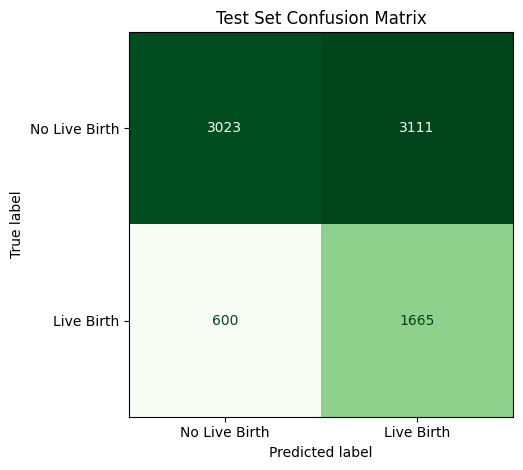




COMPUTING FOR HFEA_2015.parquet
Average optimal threshold = 0.505
AIC: -55841.645
BIC: -55052.665

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.614795,0.360709,0.732394,0.483250,0.652726
Standard Deviation,0.007628,0.007057,0.017118,0.006934,0.007588



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.611729,0.348205,0.72362,0.470166,0.640809


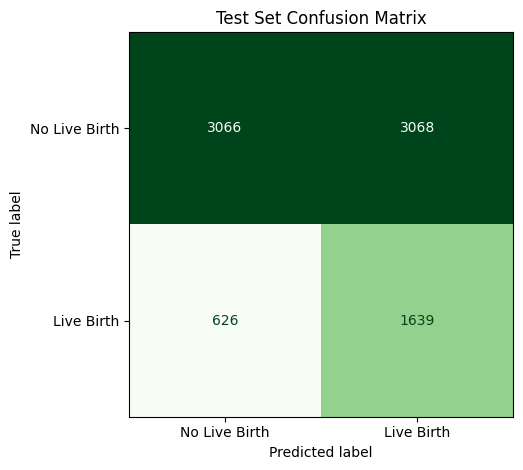

In [11]:
data_list = ['HFEA_2006.parquet', 'HFEA_2007.parquet', 'HFEA_2008.parquet', 'HFEA_2009.parquet', 'HFEA_2010.parquet',
'HFEA_2011.parquet', 'HFEA_2012.parquet', 'HFEA_2013.parquet', 'HFEA_2014.parquet', 'HFEA_2015.parquet']
TEST = pd.read_parquet('TEST_2016.parquet')
y_test = TEST['LIVE_BIRTH_OCCURRENCE']
X_test = TEST.drop(['FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'LIVE_BIRTH_OCCURRENCE'], axis=1)

year_iterator(data_list, X_test, y_test)

In [120]:
models = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']

avg_auc = [0.642, 0.645, 0.646, 0.636, 0.633, 0.633, 0.634, 0.631, 0.644, 0.653, 0.647]
std_auc = [0.011, 0.007, 0.005, 0.010, 0.011, 0.008, 0.005, 0.008, 0.011, 0.008, 0.009]
test_auc = [0.635, 0.641, 0.640, 0.640, 0.639, 0.639, 0.641, 0.637, 0.641, 0.641, 0.638]

avg_f1 = [0.435, 0.447, 0.452, 0.445, 0.442, 0.442, 0.455, 0.464, 0.476, 0.483, 0.473]
std_f1 = [0.010, 0.005, 0.007, 0.009, 0.008, 0.008, 0.006, 0.007, 0.011, 0.007, 0.007]
test_f1 = [0.454, 0.470, 0.470, 0.474, 0.470, 0.470, 0.474, 0.472, 0.473, 0.470, 0.472]

live_birth_rate = [24.75, 25.36, 25.74, 25.28, 25.68, 25.58, 26.35, 27.19, 27.74, 27.91, 27.0]


# Create figure
fig = go.Figure()

# AUC Scores
fig.add_trace(go.Scatter(
    x=models, y=avg_auc, 
    mode='lines',
    name='Avg AUC',
    line=dict(color='#FF9249')))
fig.add_trace(go.Scatter(
    x=models, y=[avg + std for avg, std in zip(avg_auc, std_auc)], 
    mode='lines',
    name='AUC + 1 std',
    marker=dict(color="#444"),
    line=dict(width=0),
    showlegend=False))
fig.add_trace(go.Scatter(
    x=models, y=[avg - std for avg, std in zip(avg_auc, std_auc)], 
    mode='lines',
    name='AUC - 1 std',
    marker=dict(color="#444"),
    line=dict(width=0),
    fillcolor='rgba(250, 199, 164, 0.4)',
    fill='tonexty',
    showlegend=False))

# F1 Scores
fig.add_trace(go.Scatter(
    x=models, y=avg_f1, 
    mode='lines',
    name='Avg F1',
    line=dict(color='#82ADAE')))
fig.add_trace(go.Scatter(
    x=models, y=[avg + std for avg, std in zip(avg_f1, std_f1)], 
    mode='lines',
    name='F1 + 1 std',
    marker=dict(color="#444"),
    line=dict(width=0),
    showlegend=False))
fig.add_trace(go.Scatter(
    x=models, y=[avg - std for avg, std in zip(avg_f1, std_f1)], 
    mode='lines',
    name='F1 - 1 std',
    marker=dict(color="#444"),
    line=dict(width=0),
    fillcolor='rgba(130, 173, 174, 0.4)',
    fill='tonexty',
    showlegend=False))

# Test Scores
fig.add_trace(go.Scatter(
    x=models, y=test_auc, 
    mode='markers',
    name='Test AUC',
    marker=dict(color='#FF9249', symbol='x')))
fig.add_trace(go.Scatter(
    x=models, y=test_f1, 
    mode='markers',
    name='Test F1',
    marker=dict(color='#82ADAE', symbol='x')))


# LBR
fig.add_trace(go.Scatter(
    x=models, y=live_birth_rate, 
    mode='lines',
    name='LBR',
    yaxis='y2', 
    line=dict(color='#302C2E'),
))

# Update layout with yaxis2 and other formatting
fig.update_layout(
    title={
        'text': 'Model Performance per Year and Live Birth Rate',
        'x': 0.5,
        'xanchor': 'center'
    },
    legend=dict(
        x=1.1,  # Move the legend further to the right
        y=1), 
    xaxis_title='Year',
    yaxis_title='Score',
    yaxis2=dict(
        title='Live Birth Rate (%)',
        overlaying='y',
        side='right',
        showgrid=False
    ),
    font=dict(
        family="Didot",
        size=14,
        color="black"
    ),
    width=1100,  
    height=500,
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showline=True, showgrid=True, gridcolor='lightgrey'),
    yaxis=dict(showline=True, showgrid=True, gridcolor='lightgrey'),
    showlegend=True
)

fig.show()


In [121]:
pio.write_image(fig, 'year.png', scale=4)

## Analysing which instances the model classifies properly

Average optimal threshold = 0.507
AIC: -43755.4
BIC: -42988.986

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.610851,0.345231,0.739429,0.470619,0.646619
Standard Deviation,0.006410,0.004565,0.019497,0.006230,0.008995



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.612452,0.347571,0.732892,0.471524,0.638383


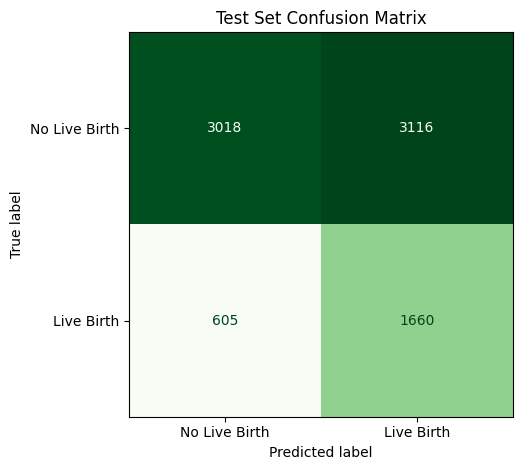


FEATURES ANALYSIS


,feature,importance_mean,importance_std
82,SPERM_FROM SPECIFIC_TREATMENT_TYPE_IVF,0.625686,0.040686
60,CAUSE_OF_INFERTILITY__MALE_FACTOR SPECIFIC_TRE...,0.438918,0.016810
7,STIMULATION_USED,0.298251,0.054099
75,STIMULATION_USED^2,0.298251,0.054099
58,CAUSE_OF_INFERTILITY__MALE_FACTOR SPERM_FROM,0.273410,0.042620
49,CAUSE_OF_INFERTILITY__OVULATORY_DISORDER STIMU...,0.200810,0.019141
64,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED STIM...,0.194009,0.020033
43,CAUSE__OF_INFERTILITY__TUBAL_DISEASE SPECIFIC_...,0.191604,0.015780
67,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED SPEC...,0.151455,0.020784
74,CAUSE_OF_INFERTILITY__ENDOMETRIOSIS PREVIOUS_L...,0.136633,0.047689


In [29]:
TRAIN = pd.read_parquet('TRAIN_2016.parquet')
TEST = pd.read_parquet('TEST_2016.parquet')

# Separate the targets from the data
y_train_live_birth = TRAIN['LIVE_BIRTH_OCCURRENCE']
y_test_live_birth = TEST['LIVE_BIRTH_OCCURRENCE']

# Remove SPECIFIC_TREATMENT_TYPE_IVF variable
X_train = TRAIN.drop(['FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'LIVE_BIRTH_OCCURRENCE'], axis=1)
X_test = TEST.drop(['FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'LIVE_BIRTH_OCCURRENCE'], axis=1)

# Optimal Squared Logistic Regression
X_train_poly = create_poly_features(X_train)
X_test_poly = create_poly_features(X_test)
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':4000, 'random_state': 42, 'class_weight': 'balanced', 'penalty':'l1', 'solver':'saga', 'C':0.1}
results_C_01 = model_pipeline(X_train_poly, y_train_live_birth, X_test_poly, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True, importances=True)

In [96]:
# Add model predictions and ground truths back to dataframe

X_test_analysis = X_test.copy()
X_test_analysis['GT'] = y_test
X_test_analysis['PREDS'] = results_C_01['y_test_pred']

# Filter to only keep Donor Sperm with IVF
X_test_analysis_donor_IVF = X_test_analysis[(X_test_analysis['SPERM_FROM']==1) & (X_test_analysis['SPECIFIC_TREATMENT_TYPE_IVF']==1)]

# Compute metrics for the sub-population
balanced_acc = balanced_accuracy_score(X_test_analysis_donor_IVF['GT'], X_test_analysis_donor_IVF['PREDS'])
roc_auc = roc_auc_score(X_test_analysis_donor_IVF['GT'], X_test_analysis_donor_IVF['PREDS'])
f1 = f1_score(X_test_analysis_donor_IVF['GT'], X_test_analysis_donor_IVF['PREDS'])
conf_matrix = confusion_matrix(X_test_analysis_donor_IVF['GT'], X_test_analysis_donor_IVF['PREDS'])

# Print metrics and confusion matrix
print('RESULTS FOR DONOR SPERM AND IVF')
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Filter to only keep Donor Sperm with IVF
X_test_analysis_donor_IVF = X_test_analysis[(X_test_analysis['SPERM_FROM']==1)]

# Compute metrics for the sub-population
balanced_acc = balanced_accuracy_score(X_test_analysis_donor_IVF['GT'], X_test_analysis_donor_IVF['PREDS'])
roc_auc = roc_auc_score(X_test_analysis_donor_IVF['GT'], X_test_analysis_donor_IVF['PREDS'])
f1 = f1_score(X_test_analysis_donor_IVF['GT'], X_test_analysis_donor_IVF['PREDS'])
conf_matrix = confusion_matrix(X_test_analysis_donor_IVF['GT'], X_test_analysis_donor_IVF['PREDS'])

# Print metrics and confusion matrix
print('RESULTS FOR DONOR SPERM')
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

print(X_test_analysis_donor_IVF['GT'].mean())

# Filter to only keep Donor Sperm with IVF
X_test_analysis_donor_IVF = X_test_analysis[(X_test_analysis['SPERM_FROM']==1) & (X_test_analysis['SPECIFIC_TREATMENT_TYPE_IVF']==0)]


print(X_test_analysis_donor_IVF['GT'].mean())


RESULTS FOR DONOR SPERM AND IVF
Balanced Accuracy: 0.6739
ROC AUC: 0.6739
F1 Score: 0.5564

Confusion Matrix:
[[125  98]
 [ 20  74]]
RESULTS FOR DONOR SPERM
Balanced Accuracy: 0.6465
ROC AUC: 0.6465
F1 Score: 0.5229

Confusion Matrix:
[[207 181]
 [ 38 120]]
0.2893772893772894
0.2794759825327511


## Multilayer Perceptron with increasing training data volume

In [15]:
def year_augmentor(data_list, X_test, y_test):
    """
    Iterates over a list of datasets in reverse order and cumulatively augments the training data.
    For each augmented training set, the function computes metrics using a Multilayer Perceptron 
    classifier and then prints the results obtained on cross-validation sets but also on a constant
    test set.

    Args:
        data_list (list of str): A list of paths to dataset files in parquet format, which will be 
                                 processed in reversed order.
        X_test (pandas.DataFrame): Features for the test set.
        y_test (pandas.Series): Target variable for the test set.

    Returns:
        None: This function only prints results and does not return a value.
    """

    y_train_full = pd.Series([], dtype='int64')
    X_train_full = pd.DataFrame()

    for dataset in reversed(data_list):

        print('COMPUTING FOR '+str(dataset))

        DATA = pd.read_parquet(dataset)
        y_train = DATA['LIVE_BIRTH_OCCURRENCE']

        if dataset != 'TRAIN_2016.parquet':
            X_train = DATA.drop(['FRESH_CYCLE', 'FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'LIVE_BIRTH_OCCURRENCE'], axis=1)
        else:
            X_train = DATA.drop(['FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'LIVE_BIRTH_OCCURRENCE'], axis=1)

        y_train_full = pd.concat([y_train_full, y_train], ignore_index=True)
        X_train_full = pd.concat([X_train_full, X_train], ignore_index=True)

        # Multilayer Perceptron
        model = MLPClassifier
        metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
        params = {'random_state': 42, 'max_iter': 10000}
        results_MLP = model_pipeline(X_train_full, y_train_full, X_test, y_test, model, metrics_list, params, 
        k=10, stratified=True, AIC=False, smote=False, SHAP=False, optimal_threshold=True)
        print('')
        print('')

    return None

COMPUTING FOR TRAIN_2016.parquet
Average optimal threshold = 0.272

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.610205,0.346075,0.729051,0.469249,0.645987
Standard Deviation,0.005350,0.004512,0.019649,0.005276,0.007668



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.608041,0.346693,0.710375,0.465972,0.63694


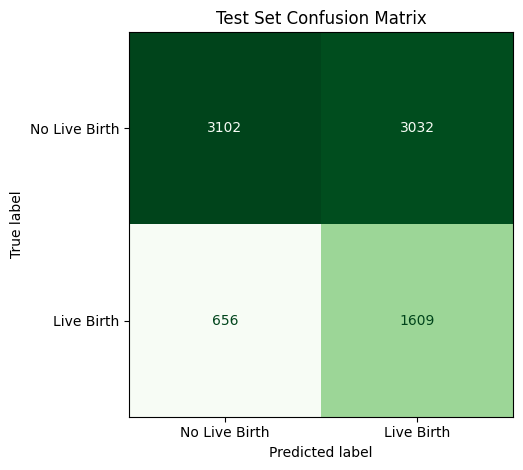




COMPUTING FOR HFEA_2015.parquet
Average optimal threshold = 0.288

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.611054,0.354871,0.715486,0.474338,0.649588
Standard Deviation,0.006146,0.005432,0.016683,0.005721,0.007322



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.610595,0.351147,0.696247,0.466844,0.64325


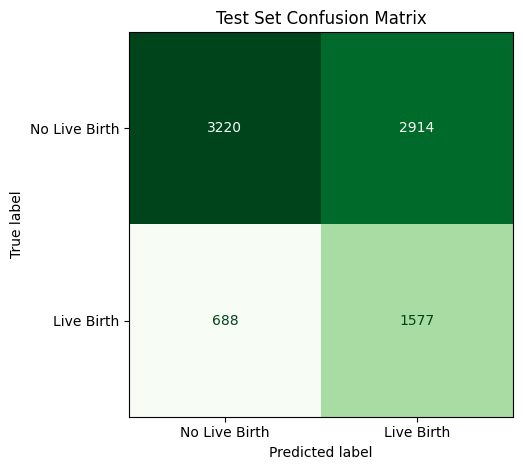




COMPUTING FOR HFEA_2014.parquet
Average optimal threshold = 0.283

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.612354,0.356548,0.718625,0.476588,0.648844
Standard Deviation,0.005339,0.003697,0.014144,0.005446,0.006201



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.609305,0.351806,0.683885,0.464607,0.64214


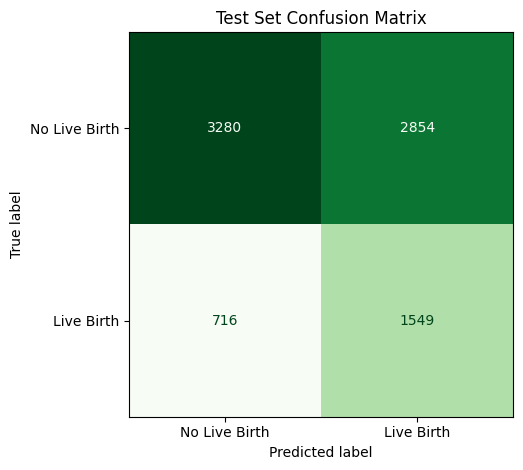




COMPUTING FOR HFEA_2013.parquet
Average optimal threshold = 0.277

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.609622,0.350748,0.734251,0.474697,0.644581
Standard Deviation,0.003196,0.002779,0.009097,0.002885,0.003781



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.613131,0.34867,0.72936,0.471798,0.641343


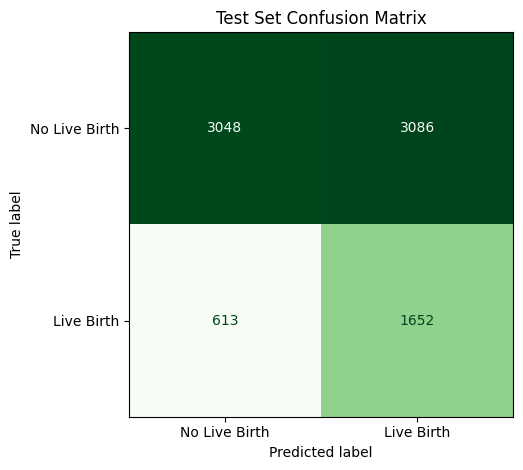




COMPUTING FOR HFEA_2012.parquet
Average optimal threshold = 0.276

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.608146,0.347832,0.726002,0.470284,0.643636
Standard Deviation,0.006423,0.005212,0.012055,0.005762,0.007569



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.611633,0.346426,0.735982,0.471104,0.64247


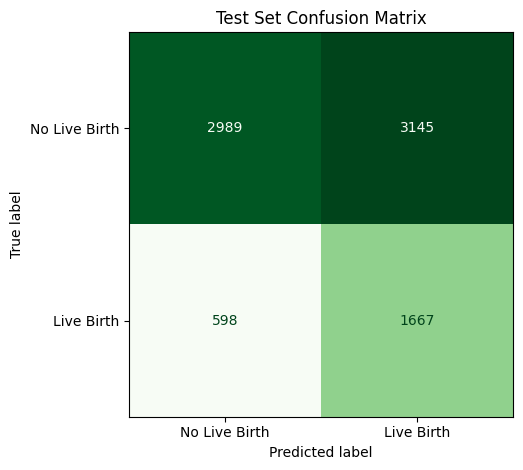




COMPUTING FOR HFEA_2011.parquet
Average optimal threshold = 0.271

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.607452,0.343840,0.726639,0.466790,0.641766
Standard Deviation,0.004054,0.002893,0.007292,0.003837,0.003495



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.611117,0.346922,0.728918,0.470103,0.640952


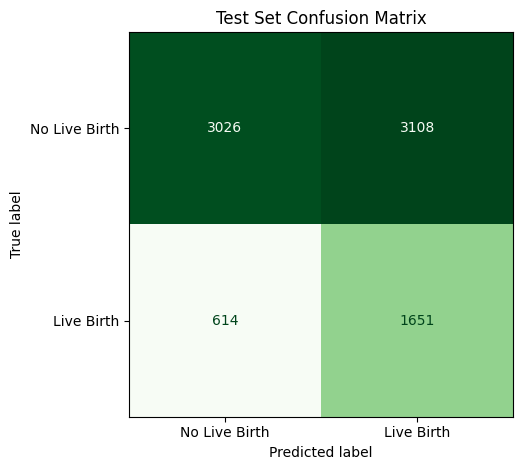




COMPUTING FOR HFEA_2010.parquet
Average optimal threshold = 0.266

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.606239,0.341104,0.723647,0.463616,0.641353
Standard Deviation,0.003229,0.002424,0.012914,0.003334,0.003482



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.612948,0.34741,0.737307,0.472285,0.641945


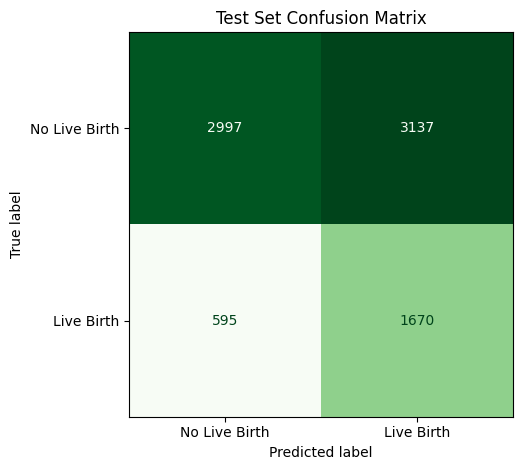




COMPUTING FOR HFEA_2009.parquet
Average optimal threshold = 0.267

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.606024,0.338506,0.726355,0.461785,0.641068
Standard Deviation,0.003468,0.002313,0.009232,0.003419,0.002609



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.614187,0.34919,0.73245,0.472919,0.642003


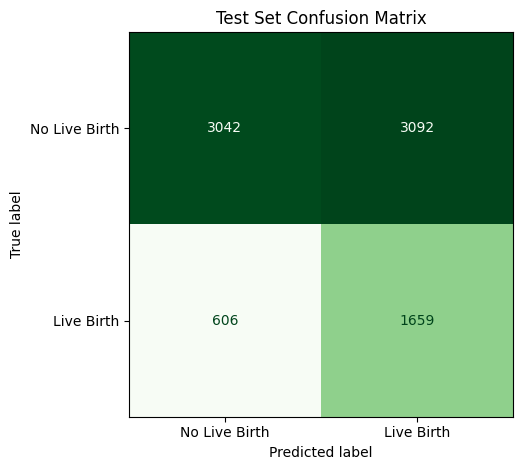




COMPUTING FOR HFEA_2008.parquet
Average optimal threshold = 0.27

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.606652,0.339006,0.719157,0.460759,0.641481
Standard Deviation,0.002758,0.001440,0.013854,0.003286,0.002275



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.607502,0.351908,0.671965,0.461912,0.641641


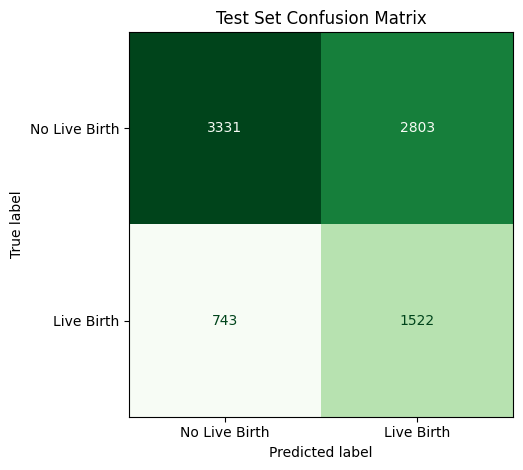




COMPUTING FOR HFEA_2007.parquet
Average optimal threshold = 0.266

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.606988,0.337449,0.725049,0.460524,0.642206
Standard Deviation,0.002144,0.001838,0.010079,0.002200,0.002808



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.614058,0.347494,0.743929,0.473714,0.641355


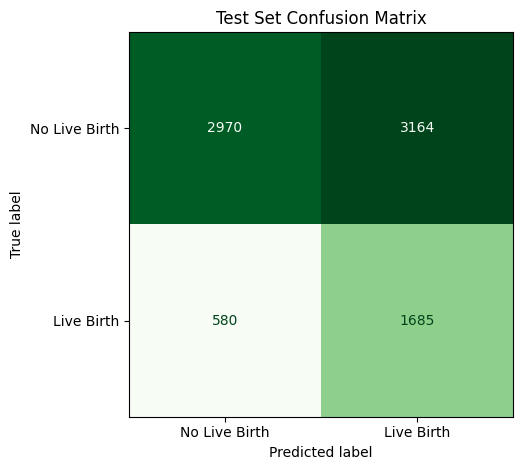




COMPUTING FOR HFEA_2006.parquet
Average optimal threshold = 0.265

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.606624,0.336172,0.721492,0.458606,0.642296
Standard Deviation,0.002709,0.002246,0.011973,0.002757,0.003190



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.61145,0.348076,0.722737,0.469862,0.642199


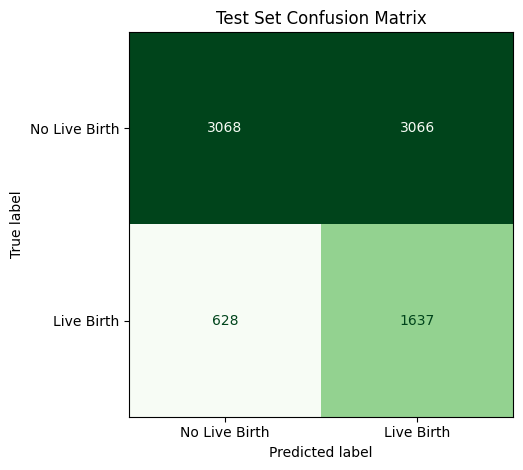

In [16]:
data_list = ['HFEA_2006.parquet', 'HFEA_2007.parquet', 'HFEA_2008.parquet', 'HFEA_2009.parquet', 'HFEA_2010.parquet',
'HFEA_2011.parquet', 'HFEA_2012.parquet', 'HFEA_2013.parquet', 'HFEA_2014.parquet', 'HFEA_2015.parquet', 'TRAIN_2016.parquet']
TEST = pd.read_parquet('TEST_2016.parquet', )
y_test = TEST['LIVE_BIRTH_OCCURRENCE']
X_test = TEST.drop(['FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'LIVE_BIRTH_OCCURRENCE'], axis=1)
year_augmentor(data_list, X_test, y_test)

In [114]:
models = ['2016', '+2015', '+2014', '+2013', '+2012', '+2011', '+2010', '+2009', '+2008', '+2007', '+2006']

avg_auc = [0.646, 0.650, 0.649, 0.645, 0.644, 0.642, 0.641, 0.641, 0.641, 0.642, 0.642]
std_auc = [0.008, 0.007, 0.006, 0.003, 0.008, 0.003, 0.003, 0.003, 0.002, 0.003, 0.003]
test_auc = [0.637, 0.643, 0.642, 0.641, 0.642, 0.641, 0.642, 0.642, 0.642, 0.641, 0.642]

avg_f1 = [0.469, 0.474, 0.477, 0.475, 0.470, 0.467, 0.464, 0.462, 0.461, 0.461, 0.459]
std_f1 = [0.005, 0.006, 0.005, 0.003, 0.006, 0.004, 0.003, 0.003, 0.003, 0.002, 0.003]
test_f1 = [0.466, 0.467, 0.465, 0.472, 0.471, 0.470, 0.472, 0.473, 0.462, 0.474, 0.470]

volume = [33595, 76645, 120444, 164242, 208208, 251064, 292404, 332028, 368884, 402440, 434817]


# Create figure
fig = go.Figure()

# AUC Scores
fig.add_trace(go.Scatter(
    x=models, y=avg_auc, 
    mode='lines',
    name='Avg AUC',
    line=dict(color='#FF9249')))
fig.add_trace(go.Scatter(
    x=models, y=[avg + std for avg, std in zip(avg_auc, std_auc)], 
    mode='lines',
    name='AUC + 1 std',
    marker=dict(color="#444"),
    line=dict(width=0),
    showlegend=False))
fig.add_trace(go.Scatter(
    x=models, y=[avg - std for avg, std in zip(avg_auc, std_auc)], 
    mode='lines',
    name='AUC - 1 std',
    marker=dict(color="#444"),
    line=dict(width=0),
    fillcolor='rgba(250, 199, 164, 0.4)',
    fill='tonexty',
    showlegend=False))

# F1 Scores
fig.add_trace(go.Scatter(
    x=models, y=avg_f1, 
    mode='lines',
    name='Avg F1',
    line=dict(color='#82ADAE')))
fig.add_trace(go.Scatter(
    x=models, y=[avg + std for avg, std in zip(avg_f1, std_f1)], 
    mode='lines',
    name='F1 + 1 std',
    marker=dict(color="#444"),
    line=dict(width=0),
    showlegend=False))
fig.add_trace(go.Scatter(
    x=models, y=[avg - std for avg, std in zip(avg_f1, std_f1)], 
    mode='lines',
    name='F1 - 1 std',
    marker=dict(color="#444"),
    line=dict(width=0),
    fillcolor='rgba(130, 173, 174, 0.4)',
    fill='tonexty',
    showlegend=False))

# Test Scores
fig.add_trace(go.Scatter(
    x=models, y=test_auc, 
    mode='markers',
    name='Test AUC',
    marker=dict(color='#FF9249', symbol='x')))
fig.add_trace(go.Scatter(
    x=models, y=test_f1, 
    mode='markers',
    name='Test F1',
    marker=dict(color='#82ADAE', symbol='x')))


# LBR
fig.add_trace(go.Scatter(
    x=models, y=volume, 
    mode='lines',
    name='Volume',
    yaxis='y2', 
    line=dict(color='#302C2E'),
))

# Update layout with yaxis2 and other formatting
fig.update_layout(
    title={
        'text': 'Model Performance with Increasing Training Volume',
        'x': 0.5,
        'xanchor': 'center'
    },
    legend=dict(
        x=1.1,  # Move the legend further to the right
        y=1), 
    xaxis_title='Cumulative Year',
    yaxis_title='Score',
    yaxis2=dict(
        title='Live Birth Rate (%)',
        overlaying='y',
        side='right',
        showgrid=False
    ),
    font=dict(
        family="Didot",
        size=14,
        color="black"
    ),
    width=1100,  
    height=500,
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showline=True, showgrid=True, gridcolor='lightgrey'),
    yaxis=dict(showline=True, showgrid=True, gridcolor='lightgrey'),
    showlegend=True
)

fig.show()


In [115]:
pio.write_image(fig, 'more_data.png', scale=4)

## Stacked Ensemble Classifier

In [11]:
def read_list_from_file(filename):
    # Try to open and read the file

    with open(filename, 'r') as f:
        list_from_file = f.readlines()

    # Remove newline characters
    list_from_file = [item.strip() for item in list_from_file]

    # Convert strings to floats
    list_from_file = [float(item) for item in list_from_file]

    return list_from_file

In [12]:
TEST = pd.read_parquet('TEST_2016.parquet')

In [58]:
# Retrieved the cascade 1 train predictions
# Stage 1 predicitons
X_test_embryos = TEST.copy()
STAGE_1_PREDICTIONS = read_list_from_file('STAGE_1_PREDICTIONS.txt')
X_test_embryos['EGGS_COLLECTED_BINARY'] = STAGE_1_PREDICTIONS
X_test_embryos = X_test_embryos[X_test_embryos['EGGS_COLLECTED_BINARY'] != 0]
# Stage 2 predicitons
X_test_live_birth = X_test_embryos.copy()
STAGE_2_PREDICTIONS = read_list_from_file('STAGE_2_PREDICTIONS.txt')
X_test_live_birth['EMBRYOS_CREATED_BINARY'] = STAGE_2_PREDICTIONS
X_test_live_birth = X_test_live_birth[X_test_live_birth['EMBRYOS_CREATED_BINARY'] != 0]
# Stage 3 predicitons
X_test_meta = X_test_live_birth.copy()
STAGE_3_PREDICTIONS = read_list_from_file('STAGE_3_PREDICTIONS.txt')
X_test_meta['LIVE_BIRTH_PRED'] = STAGE_3_PREDICTIONS
# Full set of predictions
X_test_meta_full = TEST.copy()
X_test_meta_full['CASCADE_PRED'] = X_test_meta['LIVE_BIRTH_PRED']
X_test_meta_full = X_test_meta_full.fillna(0)
X_test_meta_full = X_test_meta_full.drop(columns=['FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED'], axis=1)

# Retrieve the baseline SLR predictions and convert to binary using optimal threshold
SLR_PREDICTIONS = read_list_from_file('probas_best_baseline.txt')
X_test_meta_full['SLR_PRED'] = SLR_PREDICTIONS
X_test_meta_full['SLR_PRED'] = (X_test_meta_full['SLR_PRED'] >= 0.506).astype(int)

In [59]:
# Split into further train and test sets
y = X_test_meta_full['LIVE_BIRTH_OCCURRENCE']
X_test_meta_full = X_test_meta_full.drop(columns=['LIVE_BIRTH_OCCURRENCE'], axis=1)
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(X_test_meta_full, y, test_size=0.2, random_state=42, stratify=y)

Average optimal threshold = 0.497
AIC: -8432.999
BIC: -7697.228

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.604844,0.341274,0.734026,0.465541,0.636576
Standard Deviation,0.018254,0.014102,0.036766,0.015787,0.012133



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.60215,0.338057,0.737307,0.463567,0.619451


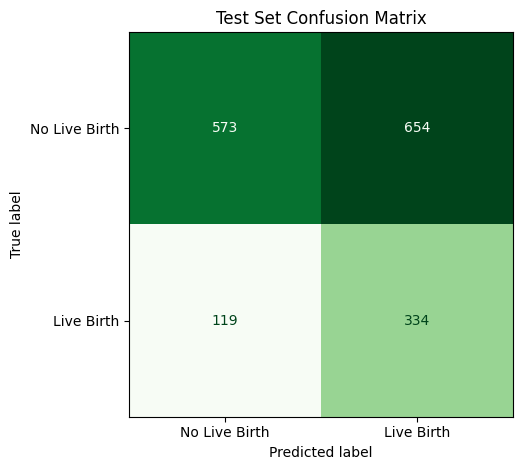


FEATURES ANALYSIS


,feature,importance_mean,importance_std
21,PATIENT_AGE_AT_TREATMENT STIMULATION_USED,0.871132,0.072057
73,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED SPER...,0.792741,0.085878
23,PATIENT_AGE_AT_TREATMENT SCREENING,0.780903,0.101908
4,CAUSE_OF_INFERTILITY__MALE_FACTOR,0.729168,0.168980
7,STIMULATION_USED,0.709824,0.219889
5,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED,0.629659,0.170155
65,CAUSE_OF_INFERTILITY__MALE_FACTOR SPERM_FROM,0.608268,0.076064
66,CAUSE_OF_INFERTILITY__MALE_FACTOR SCREENING,0.602327,0.152506
104,PREVIOUS_LIVE_BIRTH_IVF_OR_DI CASCADE_PRED,0.540331,0.051240
72,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED STIM...,0.532988,0.166298


In [61]:
# Squared Logistic Regression Meta Learner
X_train_meta_poly = create_poly_features(X_train_meta)
X_test_meta_poly = create_poly_features(X_test_meta)
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':4000, 'random_state': 42, 'class_weight': 'balanced'}
results_C_01 = model_pipeline(X_train_meta_poly, y_train_meta, X_test_meta_poly, y_test_meta, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True, importances=True)

Average optimal threshold = 0.504
AIC: -8522.029
BIC: -7970.201

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.611426,0.345193,0.749441,0.472158,0.633502
Standard Deviation,0.014922,0.013302,0.037995,0.012717,0.011646



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.605496,0.337549,0.766004,0.468602,0.627694


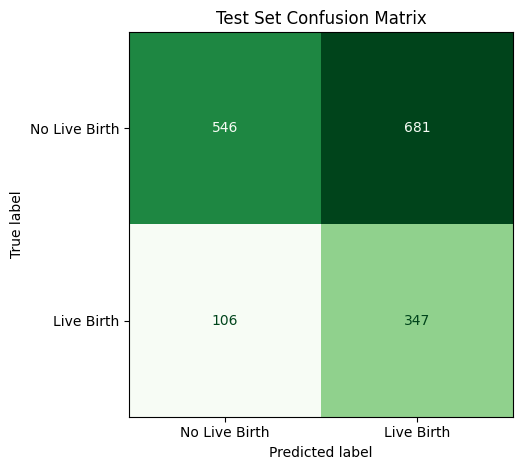


FEATURES ANALYSIS


,feature,importance_mean,importance_std
61,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED SPER...,0.967569,0.101711
21,PATIENT_AGE_AT_TREATMENT SCREENING,0.861671,0.119589
19,PATIENT_AGE_AT_TREATMENT STIMULATION_USED,0.714907,0.067415
37,CAUSE__OF_INFERTILITY__TUBAL_DISEASE CAUSE_OF_...,0.608426,0.174080
60,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED STIM...,0.584131,0.149153
56,CAUSE_OF_INFERTILITY__MALE_FACTOR SCREENING,0.583764,0.166622
59,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED CAUS...,0.542755,0.185083
55,CAUSE_OF_INFERTILITY__MALE_FACTOR SPERM_FROM,0.528303,0.065681
75,SPERM_FROM SPECIFIC_TREATMENT_TYPE_IVF,0.525602,0.091504
73,STIMULATION_USED PREVIOUS_LIVE_BIRTH_IVF_OR_DI,0.501854,0.077940


In [62]:
# Squared Logistic Regression trained on 80% of test set
X_train_meta_poly = create_poly_features(X_train_meta.drop(columns=['CASCADE_PRED', 'SLR_PRED'] , axis=1))
X_test_meta_poly = create_poly_features(X_test_meta.drop(columns=['CASCADE_PRED', 'SLR_PRED'] , axis=1))
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':4000, 'random_state': 42, 'class_weight': 'balanced'}
results_C_01 = model_pipeline(X_train_meta_poly, y_train_meta, X_test_meta_poly, y_test_meta, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True, importances=True)